In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Load and preprocess CIFAR-10
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    y_train, y_test = to_categorical(y_train), to_categorical(y_test)
    return x_train, x_test, y_train, y_test

In [4]:
# Dense Block
def dense_block(x, num_convs=3, growth_rate=12):
    concat_feat = x
    for _ in range(num_convs):
        x = layers.BatchNormalization()(concat_feat)
        x = layers.ReLU()(x)
        x = layers.Conv2D(growth_rate, (3, 3), padding='same')(x)
        concat_feat = layers.Concatenate()([concat_feat, x])
    return concat_feat


In [5]:
# Transition Layer
def transition_layer(x, reduction=0.5):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    out_channels = int(x.shape[-1] * reduction)
    x = layers.Conv2D(out_channels, (1, 1), padding='same')(x)
    x = layers.AveragePooling2D(pool_size=2, strides=2)(x)
    return x

In [6]:
# Build simplified DenseNet model
def build_model():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(24, (3, 3), padding='same')(inputs)

    x = dense_block(x, num_convs=4, growth_rate=12)
    x = transition_layer(x)

    x = dense_block(x, num_convs=4, growth_rate=12)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
# Plotting utilities
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

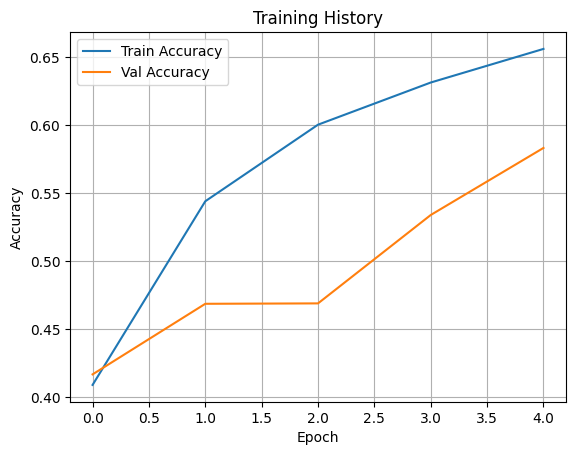

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.39      0.51      1000
           1       0.68      0.88      0.76      1000
           2       0.48      0.42      0.45      1000
           3       0.31      0.56      0.40      1000
           4       0.63      0.40      0.49      1000
           5       0.39      0.63      0.48      1000
           6       0.64      0.77      0.70      1000
           7       0.85      0.47      0.61      1000
           8       0.80      0.57      0.66      1000
           9       0.81      0.71      0.76      1000

    accuracy                           0.58     10000
   macro avg       0.64      0.58      0.58     10000
weighted avg       0.64      0.58      0.58     10000



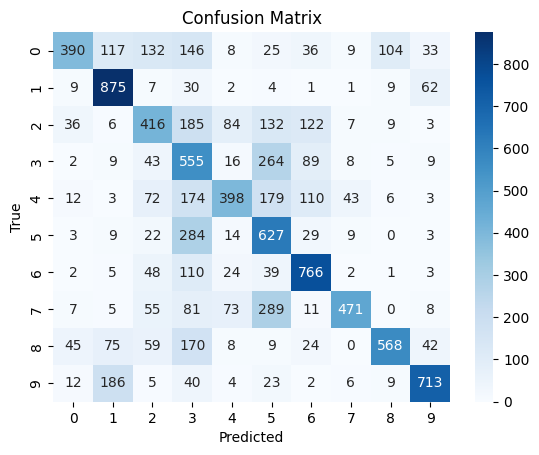

In [10]:
# Run full training pipeline
def run():
    x_train, x_test, y_train, y_test = load_data()
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=64, verbose=0)

    plot_history(history)

    y_pred = model.predict(x_test)
    print("\nClassification Report:\n")
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
    plot_confusion_matrix(y_test, y_pred)

run()